In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from sklearn.model_selection import cross_val_score

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

# I want to read the full contents of each sentiment
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

# Functions

In [164]:
def quick_boxplot(series,title,**kwargs):
    logscale = kwargs.get('logscale',True)
    fig, ax = plt.subplots(figsize=(15,5))
    sns.boxplot(data=series,orient='h')
    plt.suptitle(title)
    if logscale:
        ax.set(xscale="log")
    plt.show()

In [165]:
def quick_histogram(series,**kwargs):
    title = kwargs.get('title','Plot of series')
    xlabel = kwargs.get('xlabel','X-axis label')
    ylabel = kwargs.get('ylabel','count')
    plt.hist(series)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [166]:
def get_tukey(df,tukey_col):
    q75, q25 = np.percentile(df[tukey_col], [75 ,25])
    iqr = q75 - q25
    tukey_dict = {}
    for threshold in np.arange(1,5.5,0.5):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
#        print("The score threshold is: {}".format(threshold))
        num_outliers = len((np.where((df[tukey_col] > max_val) | (df[tukey_col] < min_val))[0]))
#        print("Number of outliers is: {}".format(num_outliers))
        tukey_dict.update({threshold: [min_val, max_val, num_outliers]})
    return tukey_dict

In [167]:
def get_tukey2(series):
    q75, q25 = np.percentile(series, [75 ,25])
    iqr = q75 - q25
    tukey_dict = {}
    for threshold in np.arange(1,5.5,0.5):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
#        print("The score threshold is: {}".format(threshold))
        num_outliers = len((np.where((series > max_val) | (series < min_val))[0]))
#        print("Number of outliers is: {}".format(num_outliers))
        tukey_dict.update({threshold: [min_val, max_val, num_outliers]})
    return tukey_dict

In [168]:
def assign_stone(ext_type):
    espensive_list = ['Stone','ImStucc','CemntBd','VinylSd']
    if (ext_type in espensive_list):
        return 1
    else:
        return 0

In [169]:
def kfold_xval(model,train_data,target_data):
    print("Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:")
    cross_val_array = cross_val_score(model, train_data, target_data, cv=10)
    print(cross_val_array)

## This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [170]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


house_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,None,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA

### Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.

In [171]:
# Filling in missing values with 0s, or "NA"
house_df['lotfrontage'].fillna(0,inplace=True)
house_df['masvnrtype'].fillna("NA",inplace=True)
house_df['masvnrarea'].fillna(0.0,inplace=True)
house_df['bsmtqual'].fillna("NA",inplace=True) 
house_df['bsmtcond'].fillna("NA",inplace=True) 
house_df['bsmtfintype1'].fillna("NA",inplace=True) 
house_df['bsmtexposure'].fillna("NA",inplace=True) 
house_df['bsmtfintype2'].fillna("NA",inplace=True) 
house_df['fireplacequ'].fillna("NA",inplace=True)
house_df['garagetype'].fillna("NA",inplace=True) 
house_df['garageyrblt'].fillna("NA",inplace=True) 
house_df['garagefinish'].fillna("NA",inplace=True) 
house_df['garagequal'].fillna("NA",inplace=True) 
house_df['garagecond'].fillna("NA",inplace=True)

In [172]:
# Dropping poorly populated or irrelevant variables
house_df.drop(columns=['id','alley','electrical','poolqc','fence','miscfeature'],inplace=True)

Performing a log transformation on lot area helps make this distribution look more normal. Let's run with that.

In [173]:
house_df['log_lotarea'] = np.log(house_df['lotarea'])

In [174]:
house_df['has_porch'] = ((house_df['openporchsf'] > 0) | (house_df['enclosedporch'] > 0) | (house_df['threessnporch'] > 0) | (house_df['screenporch'] > 0)).map({True: 1, False: 0})
house_df['has_deck'] = (house_df['wooddecksf'] > 0).map({True: 1, False: 0})
house_df['has_centralair'] = (house_df['centralair'].map({'Y': 1, 'N': 0}))
house_df['has_paveddrive'] = (house_df['paveddrive'].map({'Y': 1, 'N': 0, 'P': 0}))
house_df['has_gasheat'] = (house_df['heating'].map({'GasA': 1, 'GasW': 1, 'Grav': 0,
                                                    'Wall': 0, 'OthW': 0, 'Floor': 0}))
house_df['has_fingarage'] = (house_df['garagefinish'].map({'Fin': 1, 'RFn': 1, 'Unf': 0,'NA': 0}))
house_df['ext_stone'] = house_df['exterior1st'].apply(lambda x: assign_stone(x))

# Curious about whether the size of the house compared to the size of the lot will be significant.
# Lot area looked better after a log transformation, so let's perform that same transformation on this feature.
house_df['house_to_lot_ratio'] = np.log(house_df['grlivarea'] / house_df['lotarea'])

In [175]:
# Start with these features of interest. 
vars_of_interest = ['saleprice','log_saleprice','neighborhood','bldgtype','housestyle','yearbuilt','fireplaces',
                    'grlivarea','garagearea','has_deck','has_porch','has_centralair','has_gasheat','fullbath',
                    'has_paveddrive','has_fingarage','house_to_lot_ratio','ext_stone'
                   ]
# I'm making a copy of the dataframe that only contains the variables we might care about.
house_interest_df = house_df_no_outliers[vars_of_interest]
house_interest_df.head()

,saleprice,log_saleprice,neighborhood,bldgtype,housestyle,yearbuilt,fireplaces,grlivarea,garagearea,has_deck,has_porch,has_centralair,has_gasheat,fullbath,has_paveddrive,has_fingarage,house_to_lot_ratio,ext_stone
0,208500,12.247694,CollgCr,1Fam,2Story,2003,0,1710,548,0,1,1,1,2,1,1,-1.597673,1
1,181500,12.109011,Veenker,1Fam,1Story,1976,1,1262,460,1,0,1,1,2,1,1,-2.029065,0
2,223500,12.317167,CollgCr,1Fam,2Story,2001,1,1786,608,0,1,1,1,2,1,1,-1.840390,1
3,140000,11.849398,Crawfor,1Fam,2Story,1915,1,1717,642,0,1,1,1,1,1,0,-1.715963,0
4,250000,12.429216,NoRidge,1Fam,2Story,2000,1,2198,836,1,1,1,1,2,1,1,-1.869911,1


__Some really large and really tiny outliers are throwing everything off. Let's see if dropping them yields better results when we perform k-fold cross-validation later.__

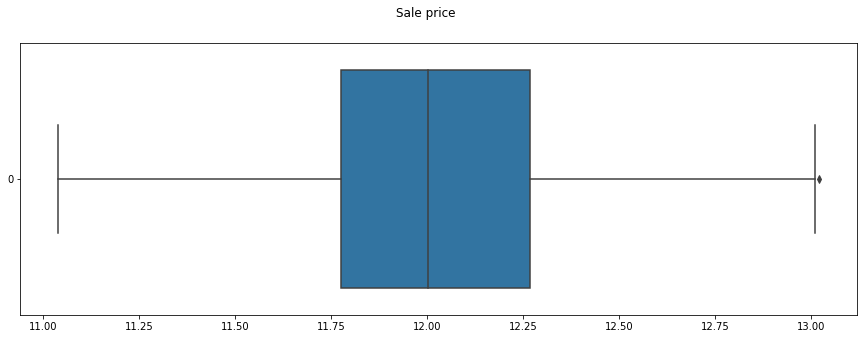

In [176]:
quick_boxplot(np.log(house_interest_df['saleprice']),'Sale price',logscale=False)

In [177]:
get_tukey2(np.log(house_interest_df['saleprice']))

{1.0: [11.281238759018287, 12.763391670276587, 60],
 1.5: [11.03421327380857, 13.010417155486303, 1],
 2.0: [10.787187788598853, 13.25744264069602, 0],
 2.5: [10.540162303389137, 13.504468125905737, 0],
 3.0: [10.29313681817942, 13.751493611115453, 0],
 3.5: [10.046111332969703, 13.99851909632517, 0],
 4.0: [9.799085847759986, 14.245544581534887, 0],
 4.5: [9.55206036255027, 14.492570066744603, 0],
 5.0: [9.305034877340553, 14.73959555195432, 0]}

In [178]:
house_interest_df['log_saleprice'] = np.log(house_interest_df['saleprice'])

The whiskers of the box plot are set at $\pm$1.5 * the IQR. Let's use that as our min/max thresholds for dropping outliers. We should drop 28 records.

In [179]:
house_interest_df = house_interest_df.loc[(house_interest_df['log_saleprice'] > 11.027146428351426) & \
                                          (house_interest_df['log_saleprice'] < 13.021682213395525)]

In [180]:
house_interest_df.describe()

,saleprice,log_saleprice,yearbuilt,fireplaces,grlivarea,garagearea,has_deck,has_porch,has_centralair,has_gasheat,fullbath,has_paveddrive,has_fingarage,house_to_lot_ratio,ext_stone
count,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000
mean,178788.431564,12.025787,1971.468575,0.610335,1508.573324,473.248603,0.481844,0.687151,0.942737,0.992318,1.562849,0.923184,0.532123,-1.840203,0.395251
std,69439.117053,0.365032,29.968544,0.640234,498.990317,208.928977,0.499845,0.463815,0.232425,0.087338,0.540688,0.266392,0.499141,0.496420,0.489075
min,62383.000000,11.041048,1872.000000,0.000000,520.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.660790,0.000000
25%,130000.000000,11.775290,1954.000000,0.000000,1134.750000,336.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-2.127114,0.000000
50%,163000.000000,12.001505,1973.000000,1.000000,1465.000000,480.000000,0.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,-1.858817,0.000000
75%,213062.500000,12.269341,2000.000000,1.000000,1771.750000,576.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,-1.632299,1.000000
max,451950.000000,13.021327,2010.000000,3.000000,5642.000000,1418.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,-0.056163,1.000000


In [181]:
# Append one-hot versions of neighborhoods and house style to the dataframe of interesting variables
house_interest_df = pd.concat([house_interest_df, pd.get_dummies(house_interest_df['neighborhood'],drop_first=True)], axis=1)
house_interest_df = pd.concat([house_interest_df, pd.get_dummies(house_interest_df['housestyle'],drop_first=True)], axis=1)
house_interest_df.describe()

,saleprice,log_saleprice,yearbuilt,fireplaces,grlivarea,garagearea,has_deck,has_porch,has_centralair,has_gasheat,fullbath,has_paveddrive,has_fingarage,house_to_lot_ratio,ext_stone,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,1.5Unf,1Story,2.5Fin,2.5Unf,2Story,SFoyer,SLvl
count,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000
mean,178788.431564,12.025787,1971.468575,0.610335,1508.573324,473.248603,0.481844,0.687151,0.942737,0.992318,1.562849,0.923184,0.532123,-1.840203,0.395251,0.001397,0.011173,0.038408,0.019553,0.104749,0.035615,0.067737,0.055168,0.021648,0.011872,0.034218,0.157123,0.006285,0.050978,0.025838,0.050279,0.076816,0.016760,0.051676,0.041201,0.060056,0.015363,0.026536,0.007682,0.009777,0.495112,0.004888,0.007682,0.304469,0.025838,0.045391
std,69439.117053,0.365032,29.968544,0.640234,498.990317,208.928977,0.499845,0.463815,0.232425,0.087338,0.540688,0.266392,0.499141,0.496420,0.489075,0.037359,0.105148,0.192246,0.138507,0.306336,0.185392,0.251383,0.228387,0.145582,0.108346,0.181852,0.364044,0.079056,0.220029,0.158707,0.218597,0.266392,0.128415,0.221449,0.198825,0.237673,0.123035,0.160780,0.087338,0.098426,0.500151,0.069769,0.087338,0.460343,0.158707,0.208233
min,62383.000000,11.041048,1872.000000,0.000000,520.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.660790,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,130000.000000,11.775290,1954.000000,0.000000,1134.750000,336.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-2.127114,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,163000.000000,12.001505,1973.000000,1.000000,1465.000000,480.000000,0.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,-1.858817,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,213062.500000,12.269341,2000.000000,1.000000,1771.750000,576.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,-1.632299,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,451950.000000,13.021327,2010.000000,3.000000,5642.000000,1418.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,-0.056163,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [209]:
hidf_features = ['grlivarea','has_porch', #'yearbuilt','garagearea',
                 'fireplaces','has_centralair',#'fullbath','has_gasheat','has_paveddrive',
                 'has_fingarage','house_to_lot_ratio','ext_stone',
                 'Edwards','Mitchel','NoRidge','NridgHt',
                 'Sawyer','StoneBr', #'SawyerW',
                 '1Story',
                ]

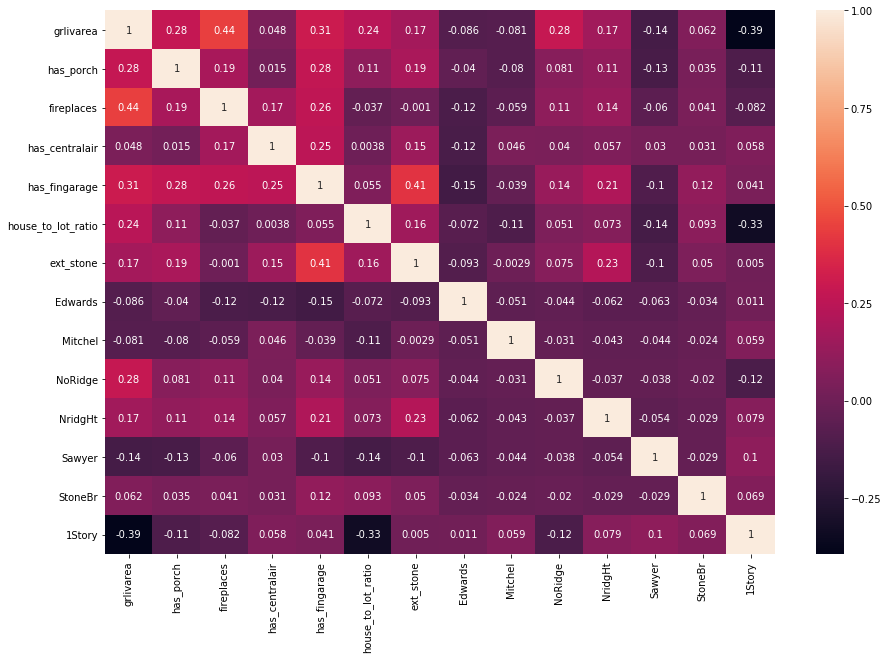

In [210]:
fig=plt.figure(figsize=(15,10))
sns.heatmap(house_interest_df[hidf_features].corr(),annot=True)

### Now, split your data into train and test sets where 20% of the data resides in the test set.

__NOTE:__ Performing a log transformation on the dependent variable (home sale price) made its distribution much more normal, and made the model fit better.

In [211]:
# Y is the target variable
Y = np.log(house_interest_df['saleprice'])

# X is the feature set.
X = house_interest_df[hidf_features]

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)#, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1145
The number of observations in test set is 287


### Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!

In [213]:
# We add constant to the model as it's a best practice
# to do so every time!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     225.6
Date:                Fri, 02 Aug 2019   Prob (F-statistic):          4.45e-315
Time:                        09:13:13   Log-Likelihood:                 291.51
No. Observations:                1145   AIC:                            -553.0
Df Residuals:                    1130   BIC:                            -477.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 10.9044      0.040    272.183      0.000      10.826      10.983
grlivarea              0.0004   1.47e-05     24.348      0.000       0.000       0.000
has_porch              0.0359      0.013      2.786      0.005       0.011       0.061
fireplaces             0.0695      0.010      6.697      0.000       0.049       0.090
has_centralair         0.1914      0.024      7.839      0.000       0.144       0.239
has_fingarage          0.1698      0.014     12.447      0.000       0.143       0.197
house_to_lot_ratio    -0.0801      0.012     -6.569      0.000      -0.104      -0.056
ext_stone              0.1137      0.013      8.644      0.000       0.088       0.140
Edwards               -0.1343      0.023     -5.932      0.000      -0.179      -0.090
Mitchel               -0.0123      0.031     -0.393      0.695      -0.074       0.049
NoRidge                0.1627      0.037      4.422      0.000       0.091       0.235
NridgHt                0.2412      0.027      8.963      0.000       0.188       0.294
Sawyer                -0.0694      0.026     -2.682      0.007      -0.120      -0.019
StoneBr                0.2829      0.045      6.333      0.000       0.195       0.371
1Story                 0.0780      0.013      6.008      0.000       0.053       0.104
==============================================================================
Omnibus:                      265.840   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1853.080
Skew:                          -0.882   Prob(JB):                         0.00
Kurtosis:                       8.978   Cond. No.                     1.29e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

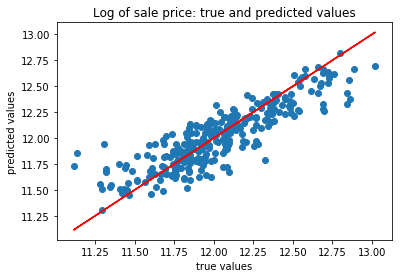

Mean absolute error of the prediction is: 0.1353140737505982
Mean squared error of the prediction is: 0.03263816298322039
Root mean squared error of the prediction is: 0.18066035254925303
Mean absolute percentage error of the prediction is: 1.1271688695610607


In [214]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Log of sale price: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

## Try OLS, Lasso, Ridge, and ElasticNet regression using the same model specification. This time, you need to do k-fold cross-validation to choose the best hyperparameter values for your models. Which model is the best? Why?

(OLS results are above. I didn't use k-fold cross-validation but I can if you really want...?)

In [215]:
# I learned that the estimator object (first parameter) needs to be from the sklearn module--
# I can't use sm.OLS. :)
kfold_xval(LinearRegression(),X,Y)

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.82080698 0.79335023 0.79764195 0.73937553 0.71097574 0.74274144
 0.75222691 0.69031929 0.45813472 0.74138244]


In [216]:
from sklearn.linear_model import HuberRegressor
kfold_xval(HuberRegressor(),X_train,y_train)

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[-2.83448411 -0.92133976 -1.11918854 -1.10081752 -0.82975306 -2.32648885
 -6.39313087 -0.83082187 -2.87956937 -0.48577797]


I read up out of curiosity---by default, cross_val_score uses the $R^2$ stat for scoring--so unfortunately what we're seeing here is a range of scores from 59% - 86%, which means we're probably overfitting. The test run above has an $R^2$ value of around 80%.

So if we are overfitting, how do we fix that?

__Moving on for now, here is Ridge:__

I started with `alpha=10**1` and kept increasing the exponent, until the folds reported back numbers that are reasonably close to each other. Above and below `10**9`, one of the folds was consistently a lot lower than the others. Further tuning to `10.5**9` brought the $R^2$ values down, but also brought them to within 5% of each other.

In [159]:
from sklearn.linear_model import Ridge
kfold_xval(Ridge(alpha=10.5**9),X_train,y_train)

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.13855953 0.14720939 0.17635753 0.18035887 0.17135091 0.10574604
 0.16261133 0.18222481 0.15669642 0.12834592]


In [160]:
kfold_xval(Ridge(),X_train,y_train)

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.84672667 0.84782913 0.81686489 0.84664091 0.79794734 0.7840689
 0.84500664 0.60824984 0.86417086 0.80672413]


These $R^2$ values seem terrible, but the lesson material suggests this may be okay? How does this look with the full test set?

In [161]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=10**9) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.24121662318146386
-----Test set statistics-----
R-squared of the model on the test set is: 0.23283128903381034
Mean absolute error of the prediction is: 0.2697219862740252
Mean squared error of the prediction is: 0.12264020710074258
Root mean squared error of the prediction is: 0.3502002385789344
Mean absolute percentage error of the prediction is: 2.2400293032713154


__LASSO:__

Again, just manually increasing the exponent, `alpha=11**2` seems to offer consistent results across folds.

In [162]:
from sklearn.linear_model import Lasso
kfold_xval(Lasso(alpha=11**2),X_train,y_train)

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.14138157 0.13308113 0.17887257 0.18023036 0.16907666 0.10871206
 0.15598323 0.17610775 0.16163186 0.13119041]


In [163]:
kfold_xval(Lasso(),X_train,y_train)

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.750468   0.76845218 0.74908458 0.78437912 0.69062256 0.72158704
 0.78132398 0.51300338 0.7587733  0.69870091]


In [164]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
lassoregr = Lasso(alpha=11**2) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.24121662318146386
-----Test set statistics-----
R-squared of the model on the test set is: 0.23283128903381034
Mean absolute error of the prediction is: 0.2844764151385211
Mean squared error of the prediction is: 0.13520079677147795
Root mean squared error of the prediction is: 0.36769660968178364
Mean absolute percentage error of the prediction is: 2.361975864240967


__ElasticNet:__

I played with values of alpha until I saw the scores become reasonably close, and ultimately stuck with `12**2`. For further tuning I tried different values for l1_ratio and finally decided upon `.8`, meaning `alpha1=12**2 * .8` and `alpha2=12**2 * (1 - .8)=12**2 * .2`

In [165]:
from sklearn.linear_model import ElasticNet

from sklearn.linear_model import Lasso
kfold_xval(ElasticNet(alpha=12**2,l1_ratio=.8),X_train,y_train)

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.17357994 0.16181236 0.21447205 0.2152478  0.20155339 0.13576249
 0.18965302 0.21041986 0.18866833 0.15513277]


In [166]:
kfold_xval(ElasticNet(),X_train,y_train)

Cross-validation array using 10 folds. Ideally, the values in this array are close to the same:
[0.76562056 0.78746445 0.76275276 0.78972206 0.6947493  0.74149237
 0.7952768  0.51741836 0.77011267 0.72057815]


In [167]:
elasticregr = ElasticNet(alpha=12**2, l1_ratio=.8) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.1936259939438013
-----Test set statistics-----
R-squared of the model on the test set is: 0.18381961208255027
Mean absolute error of the prediction is: 0.27877498336017004
Mean squared error of the prediction is: 0.1304752531939117
Root mean squared error of the prediction is: 0.36121358390004066
Mean absolute percentage error of the prediction is: 2.3148212791879215
